## 示例怎么能够产生一幅艺术

假设我们有一幅大师的画作了，我们怎么能够提取出“大师作品”中的纹理和颜色这些细节让我们的计算机知道，而不是只看到画的整体造型呢？

对于这个提取特征的问题我们先放一下，如果我们已经有了这些特征，我们要如何应用这些特征到我们新的图片上去呢？我们要将原有图片的风格干净的滤除掉，换作我们指定的风格。
看下面的图片

![](http://bos.nj.bpc.baidu.com/v1/agroup/827d60e3d97b35ce6cdf03e73d2b62b3b77b6bb6)


我们称风格画为s，原画为c，转换后的画为x，并且我们有两个评判函数：

![](https://harishnarayanan.org/images/writing/artistic-style-transfer/content-loss.png)
代表内容的差异

![](https://harishnarayanan.org/images/writing/artistic-style-transfer/style-loss.png)
代表风格的差异

此时我们要做的就变为了一个优化问题，我们要找到画x，使得内容差函数和风格差函数都很小

那怎么定义这些差异函数呢？在论文[A Neural Algorithm of Artistic Style](https://arxiv.org/pdf/1508.06576.pdf)中，定义的差距不是通过像素点之间的不同，而是从更高的层级，更感性的不同上去

于是问题就变为了怎么让计算机去知道图片的像素点之上的更具有表现力的意义上去，怎么能更好的理解图片。

对于这种看着很直观，但是很难通过具体的步骤去告诉计算机怎么做的问题，一个很有利的工具就是机器学习，下面就让我们来看看怎么去解决上面提到的计算机理解图片的问题，以及定义内容和样式的差异函数。

## CNN 图片分类
我们在解决上面问题前，先来看下图片分类问题，我们尝试着找到下面的一个函数

![](https://harishnarayanan.org/images/writing/artistic-style-transfer/image-classification-problem.png)

输入是一些数组，输出是一个分类，告诉我们这是不是一个小孩子，我们以前的想法都是看到函数f，我们就尝试着去创造各种各样的函数f，让f尽可能的捕捉到图片的特征，但是即使我们找出了这么个函数，但是如果遇到狗、猫、马等等呢，我们又必须重新去找f嘛？这显然不可能，因此我们需要摆脱以往的自己找函数，转而告诉计算机你怎么去找出这个函数，让这么复杂的工作交给机器去做，我们只要不断去纠正机器，说这个结果是好还是坏，如果不好，怎么改正去的。

上面的这个过程我们通过下图再具体的解释下：
![](https://harishnarayanan.org/images/writing/artistic-style-transfer/supervised-learning.png)

我们有很多标记好的图片，现在我们要去找一个score函数，即评分函数，能够对输入的图片给出一个打分，告诉我们是哪个分类的分值最高，接着我们有一个评价函数Loss去评判分类的好坏，如果分类不好，我们会有一个优化函数去优化score中的变数，然后重新进行分类，直到我们的Loss符合我们的预期

基于上面的思路，在2014’s ImageNet Challenge比赛上，出现了[VGGNet](https://arxiv.org/abs/1409.1556),并在次年出了一篇[论文](https://arxiv.org/abs/1409.1556)详细的进行了介绍

到这里，我们整理下我们的思路：

1. CNN通过学习，已经得到了我们需要的一些语义性的信息
2. CNN中越是后面的层级，其学习到的越是一些具体的形状，但是这些具体的形状对于像素什么颜色啥的不做要求，因此我们就可以通过高层级来定义图片的风格style
3. 在CNN中图片内容和风格是可分离的

下面我们来具体实现下

## talk is cheap, show me the code!

## 参考
https://harishnarayanan.org/writing/artistic-style-transfer/

In [1]:
import time
from PIL import Image
import numpy as np

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

Using TensorFlow backend.


接着我们将content image和style image都加载进来

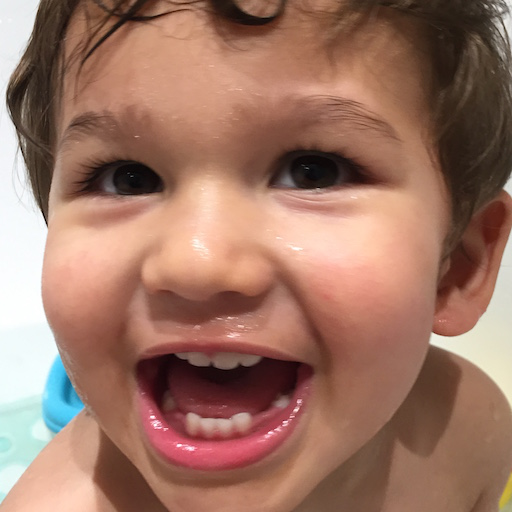

In [2]:
height = 512
width = 512

content_image_path = 'images/hugo.jpg'
content_image = Image.open(content_image_path)
content_image = content_image.resize((height, width))
content_image


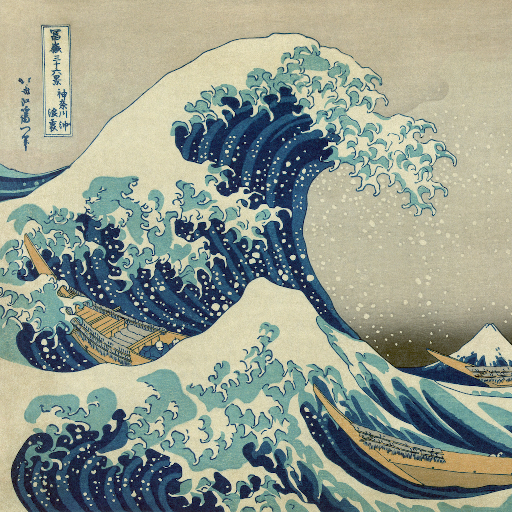

In [4]:
style_image_path = 'images/styles/wave.jpg'
style_image = Image.open(style_image_path)
style_image = style_image.resize((height, width))
style_image

接着我们将图片内容进行转换，转换到我们后续处理适合的形式

In [5]:
content_array = np.asarray(content_image, dtype='float32')
content_array = np.expand_dims(content_array, axis=0)
print(content_array.shape)

style_array = np.asarray(style_image, dtype='float32')
style_array = np.expand_dims(style_array, axis=0)
print(style_array.shape)

(1, 512, 512, 3)
(1, 512, 512, 3)


下一步为了符合[ Simonyan and Zisserman (2015)](https://arxiv.org/abs/1409.1556)中描述的数据输入格式，我们要做下面的转换

1. 减去RGB的平均值，在[ ImageNet training set ](http://image-net.org/)中计算得到的，
2. 将RGB的顺序变为BGR

In [6]:
content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array = content_array[:, :, :, ::-1]

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array = style_array[:, :, :, ::-1]

接着我们定义了在Keras中的3个变量

In [7]:
content_image = backend.variable(content_array)
style_image = backend.variable(style_array)
combination_image = backend.placeholder((1, height, width, 3))

In [8]:
# 我们将其组合到一起
input_tensor = backend.concatenate([content_image,
                                    style_image,
                                    combination_image], axis=0)

在Keras中有训练好的VGG模型，此处我们使用在[Johnson et al. (2016)](https://arxiv.org/abs/1603.08155)中提出的VGG16模型，
我们可以通过下面的语句方便的使用训练好的模型

In [9]:
model = VGG16(input_tensor=input_tensor, weights='imagenet',
              include_top=False)

在Keras中对于VGG16的每一层都有自己的名字和输出，我们可以方便的取到
此处我们取的16层模型，最先的19层模型可以看地址：http://ethereon.github.io/netscope/#/gist/3785162f95cd2d5fee77

In [10]:
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers

{'block1_conv1': <tf.Tensor 'Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'Relu_1:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'MaxPool:0' shape=(3, 256, 256, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'Relu_2:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'Relu_3:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'MaxPool_1:0' shape=(3, 128, 128, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'Relu_4:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'Relu_5:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'Relu_6:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'MaxPool_2:0' shape=(3, 64, 64, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'Relu_7:0' shape=(3, 64, 64, 512) dtype=float32>,
 'block4_conv2': <tf.Tensor 'Relu_8:0' shape=(3, 64, 64, 512) dtype=float32>,
 'block4_conv3': <tf.Tensor 'Relu_9:0' shape=(3

下面我们来回到我们之前要做的事情，我们需要定义图片内容和风格的差异，现在我们有了VGG16之后，我们就可以开始了，先初始化一些变量

In [12]:
content_weight = 0.025
style_weight = 5.0
total_variation_weight = 1.0

下面我们将开始使用VGG16的各个层来定义内容和风格这两个比较抽象的东西

In [13]:
loss = backend.variable(0.)

## 内容差异函数


我们来看看不同层级出来的图片信息


In [27]:
layer_features = layers['block2_conv2']
content_image_features = layer_features[0, :, :, :]
content_image_features.shape

TensorShape([Dimension(256), Dimension(256), Dimension(128)])

In [14]:
def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

layer_features = layers['block2_conv2']
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss += content_weight * content_loss(content_image_features,
                                      combination_features)

In [15]:
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

In [16]:

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height * width
    return backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']
for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl

In [17]:
def total_variation_loss(x):
    a = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))

loss += total_variation_weight * total_variation_loss(combination_image)

In [18]:
grads = backend.gradients(loss, combination_image)

In [19]:
outputs = [loss]
outputs += grads
f_outputs = backend.function([combination_image], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [20]:
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

iterations = 10

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 8.07324e+10
Iteration 0 completed in 80s
Start of iteration 1
Current loss value: 5.27136e+10
Iteration 1 completed in 37s
Start of iteration 2
Current loss value: 4.3404e+10
Iteration 2 completed in 37s
Start of iteration 3
Current loss value: 3.98068e+10
Iteration 3 completed in 37s
Start of iteration 4
Current loss value: 3.80434e+10
Iteration 4 completed in 37s
Start of iteration 5
Current loss value: 3.70919e+10
Iteration 5 completed in 37s
Start of iteration 6
Current loss value: 3.65379e+10
Iteration 6 completed in 37s
Start of iteration 7
Current loss value: 3.61779e+10
Iteration 7 completed in 37s
Start of iteration 8
Current loss value: 3.59321e+10
Iteration 8 completed in 37s
Start of iteration 9
Current loss value: 3.57626e+10
Iteration 9 completed in 37s


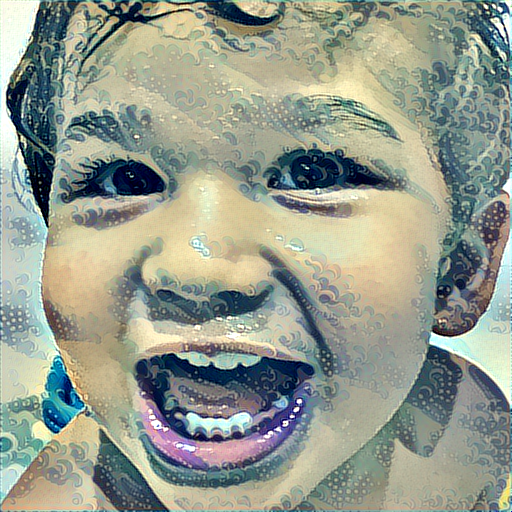

In [21]:
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

Image.fromarray(x)